In [1]:
!pip install tslearn

     |████████████████████████████████| 798kB 6.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
plt.style.use('seaborn')
import os

In [23]:
BASE_DIR = '/content/drive/My Drive/4th Year/CS 197 (Thesis)/FINAL - COVID Modeling/notebooks/data/'
file_path = os.path.join(BASE_DIR, 'combined_added_shifts_6months.csv')
df = pd.read_csv(file_path, index_col=0)

In [24]:
df.head()

Province/State Country/Region       Lat  ...  shift 14  shift 15 shift 16
0    no province    Afghanistan  33.93911  ...        -1        -1       -1
1    no province        Albania  41.15330  ...        -1        -1       -1
2    no province        Algeria  28.03390  ...        -1        -1       -1
3    no province      Argentina -38.41610  ...         8        -1       -1
4    no province        Armenia  40.06910  ...        -1        -1       -1

[5 rows x 361 columns]

# K-Shape using tslearn

## Combined

In [25]:
MAX_SHIFTS = 16
data = df.iloc[:, -MAX_SHIFTS:]
data.head()

shift 1  shift 2  shift 3  shift 4  ...  shift 13  shift 14  shift 15  shift 16
0        0        0        0        0  ...        -1        -1        -1        -1
1        1        7        8        8  ...        -1        -1        -1        -1
2        0        0        1        2  ...        -1        -1        -1        -1
3        1        7        8        4  ...         7         8        -1        -1
4        1        7        8        8  ...        -1        -1        -1        -1

[5 rows x 16 columns]

In [26]:
from tslearn.clustering import KShape

class TimeSeriesModel:
  n_clusters = 0
  data = []
  model = None

  def __init__(self, n_clusters, data):
    self.n_clusters = n_clusters
    self.data = data
  
  def build_model(self, max_iter=100):
    model = KShape(n_clusters=self.n_clusters, max_iter=max_iter)
    model.fit(self.data)
    self.model = model

    return model

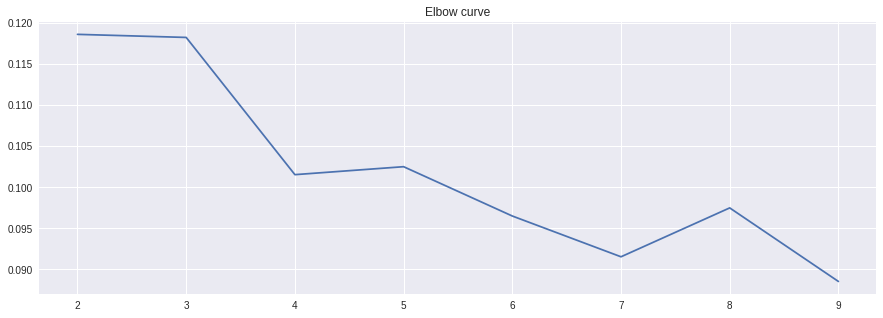

In [27]:
# is it normal that whenever you run this cell, the shape changes?
# Elbow method
def get_elbow(data):
  X = data
  distortions = []
  for k in range(2, 10):
    model_class = TimeSeriesModel(n_clusters=k, data=X)
    model = model_class.build_model()
    distortions.append(model.inertia_)

  fig = plt.figure(figsize=(15, 5))
  fig.add_axes()
  plt.plot(range(2, 10), distortions)
  plt.grid(True)
  plt.title('Elbow curve')

get_elbow(data)

In [28]:
# Number of clusters is based on the elbow method
NUM_CLUSTERS = 4

model_class = TimeSeriesModel(n_clusters=NUM_CLUSTERS, data=data)
model = model_class.build_model()

In [29]:
model.cluster_centers_[0]

array([[-0.32663996],
       [-0.32663996],
       [-0.25551972],
       [ 0.35098318],
       [ 1.91424422],
       [ 2.86200482],
       [ 0.7064373 ],
       [-0.10488132],
       [-0.58636905],
       [-0.75099863],
       [-0.79325404],
       [-0.7983693 ],
       [-0.75031882],
       [-0.55378894],
       [-0.20310271],
       [-0.38378706]])

In [30]:
df['labels'] = model.labels_
df.head()

Province/State Country/Region       Lat  ...  shift 15  shift 16 labels
0    no province    Afghanistan  33.93911  ...        -1        -1      2
1    no province        Albania  41.15330  ...        -1        -1      1
2    no province        Algeria  28.03390  ...        -1        -1      2
3    no province      Argentina -38.41610  ...        -1        -1      3
4    no province        Armenia  40.06910  ...        -1        -1      2

[5 rows x 362 columns]

In [31]:
cluster1 = df[df['labels']==1]
countries = set(cluster1['Country/Region'])
ss = ','.join(countries)
ss

'South Africa,Belize,El Salvador,Belarus,Albania,Bolivia,France,Tunisia,Morocco,Georgia,Panama,Portugal,Israel,United Kingdom,Spain,Namibia,Malta,Eswatini,Sri Lanka,Burma,Indonesia,Ireland'

## Graphing the Clusters

In [32]:
# All countries
def get_graphs(df, cluster_num=0, last_columns=18):
  fig=plt.figure(figsize=(50,20))
  ax=fig.add_axes([0,0,1,1])
  ax.set_xlabel("Dates")
  ax.set_ylabel("Cases")

  df_cluster = df[df['labels'] == cluster_num]
  for idx, area in df_cluster.iterrows():
    x = area.index[6:-last_columns]
    y = [area[i] for i in x]
    
    ax.plot(x,y,label=area['Country/Region'])
    #comment out the line below to remove the labels of the area names.
    ax.legend()

In [ ]:
# for cols in df.columns[6::-37]:
#     df[cols][df[cols]<0]=0


In [33]:
for cols in df.columns[6:-MAX_SHIFTS-2]:
    if cols[-1]=='x':
        df=df.rename(columns={cols:cols[:-1]+'confirmed'})
    elif cols[-1]=='y':
        df=df.rename(columns={cols:cols[:-1]+'deaths'})
    # else:
    #     df=df.rename(columns={cols:cols+"_recovered"})
df.columns[6:-MAX_SHIFTS-2]

Index(['11/1/20_confirmed', '11/2/20_confirmed', '11/3/20_confirmed',
       '11/4/20_confirmed', '11/5/20_confirmed', '11/6/20_confirmed',
       '11/7/20_confirmed', '11/8/20_confirmed', '11/9/20_confirmed',
       '11/10/20_confirmed',
       ...
       '4/9/21_deaths', '4/10/21_deaths', '4/11/21_deaths', '4/12/21_deaths',
       '4/13/21_deaths', '4/14/21_deaths', '4/15/21_deaths', '4/16/21_deaths',
       '4/17/21_deaths', '4/18/21_deaths'],
      dtype='object', length=338)

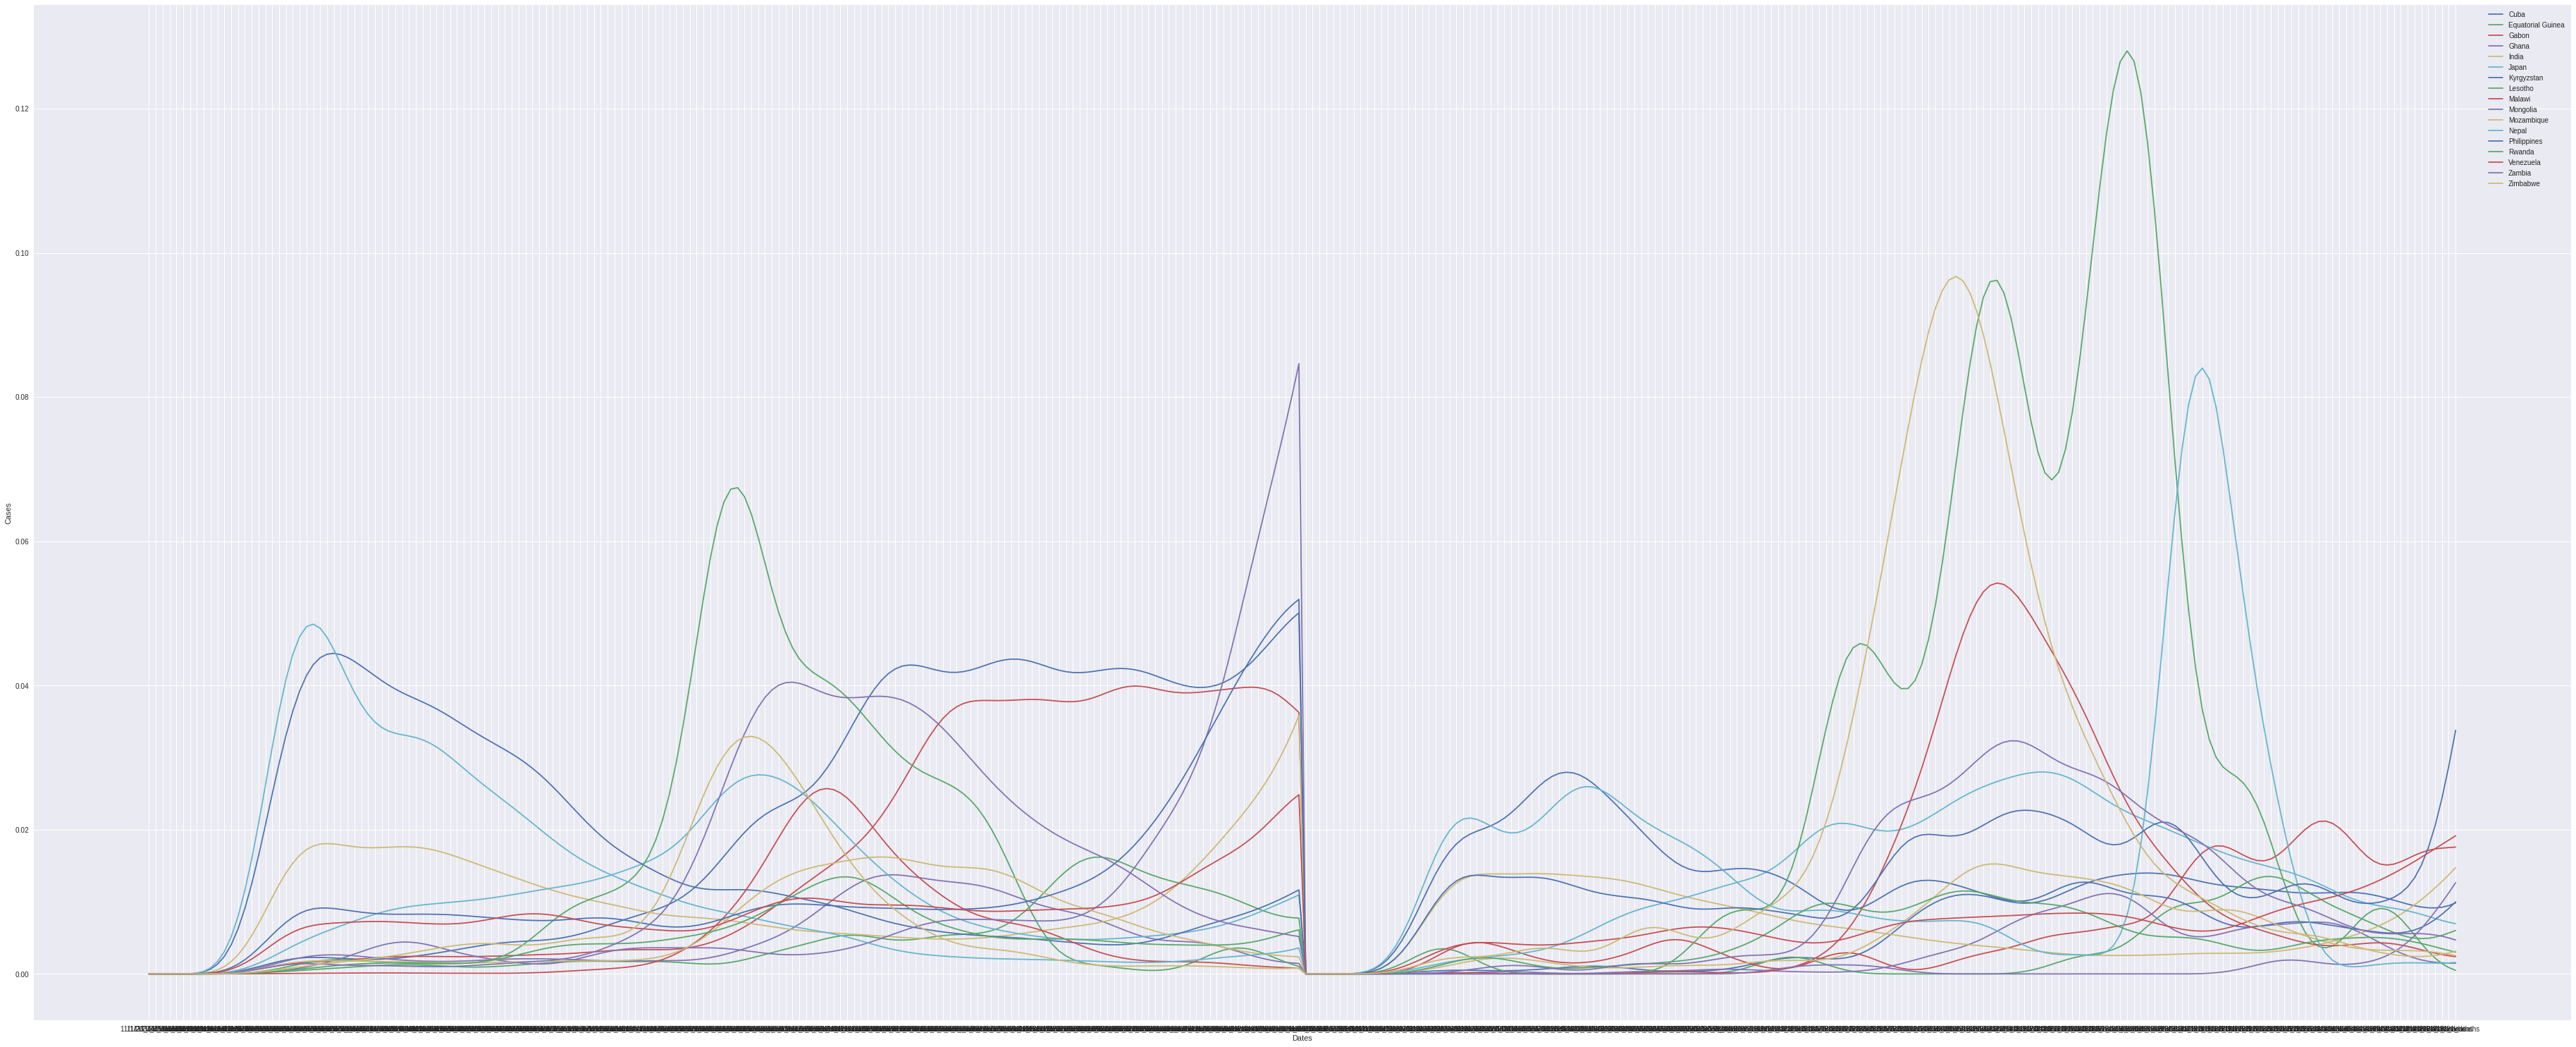

In [34]:
get_graphs(df, cluster_num=0)

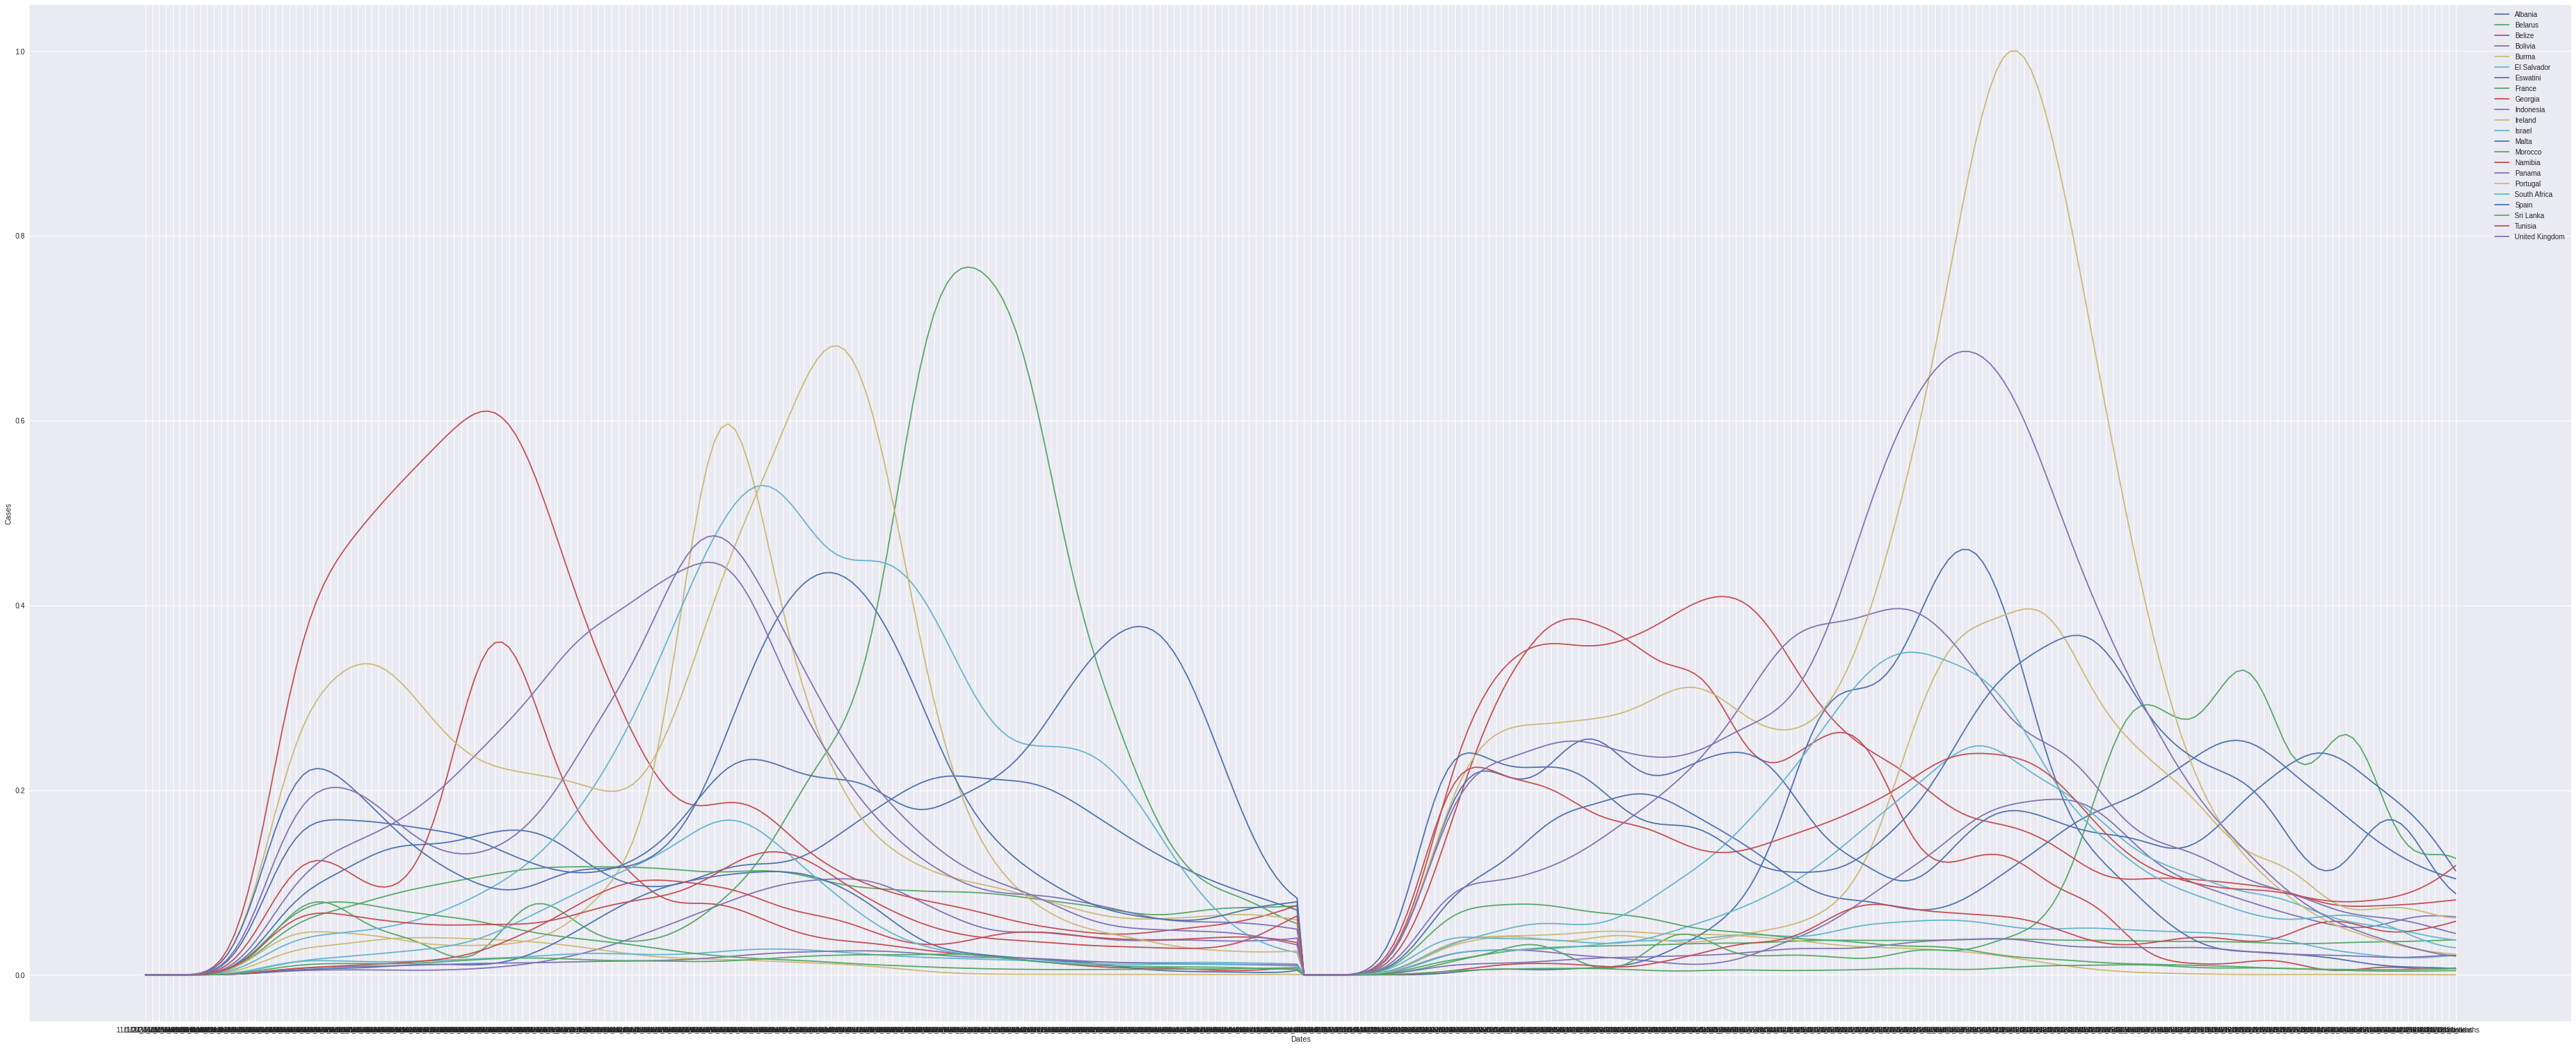

In [35]:
get_graphs(df, cluster_num=1)

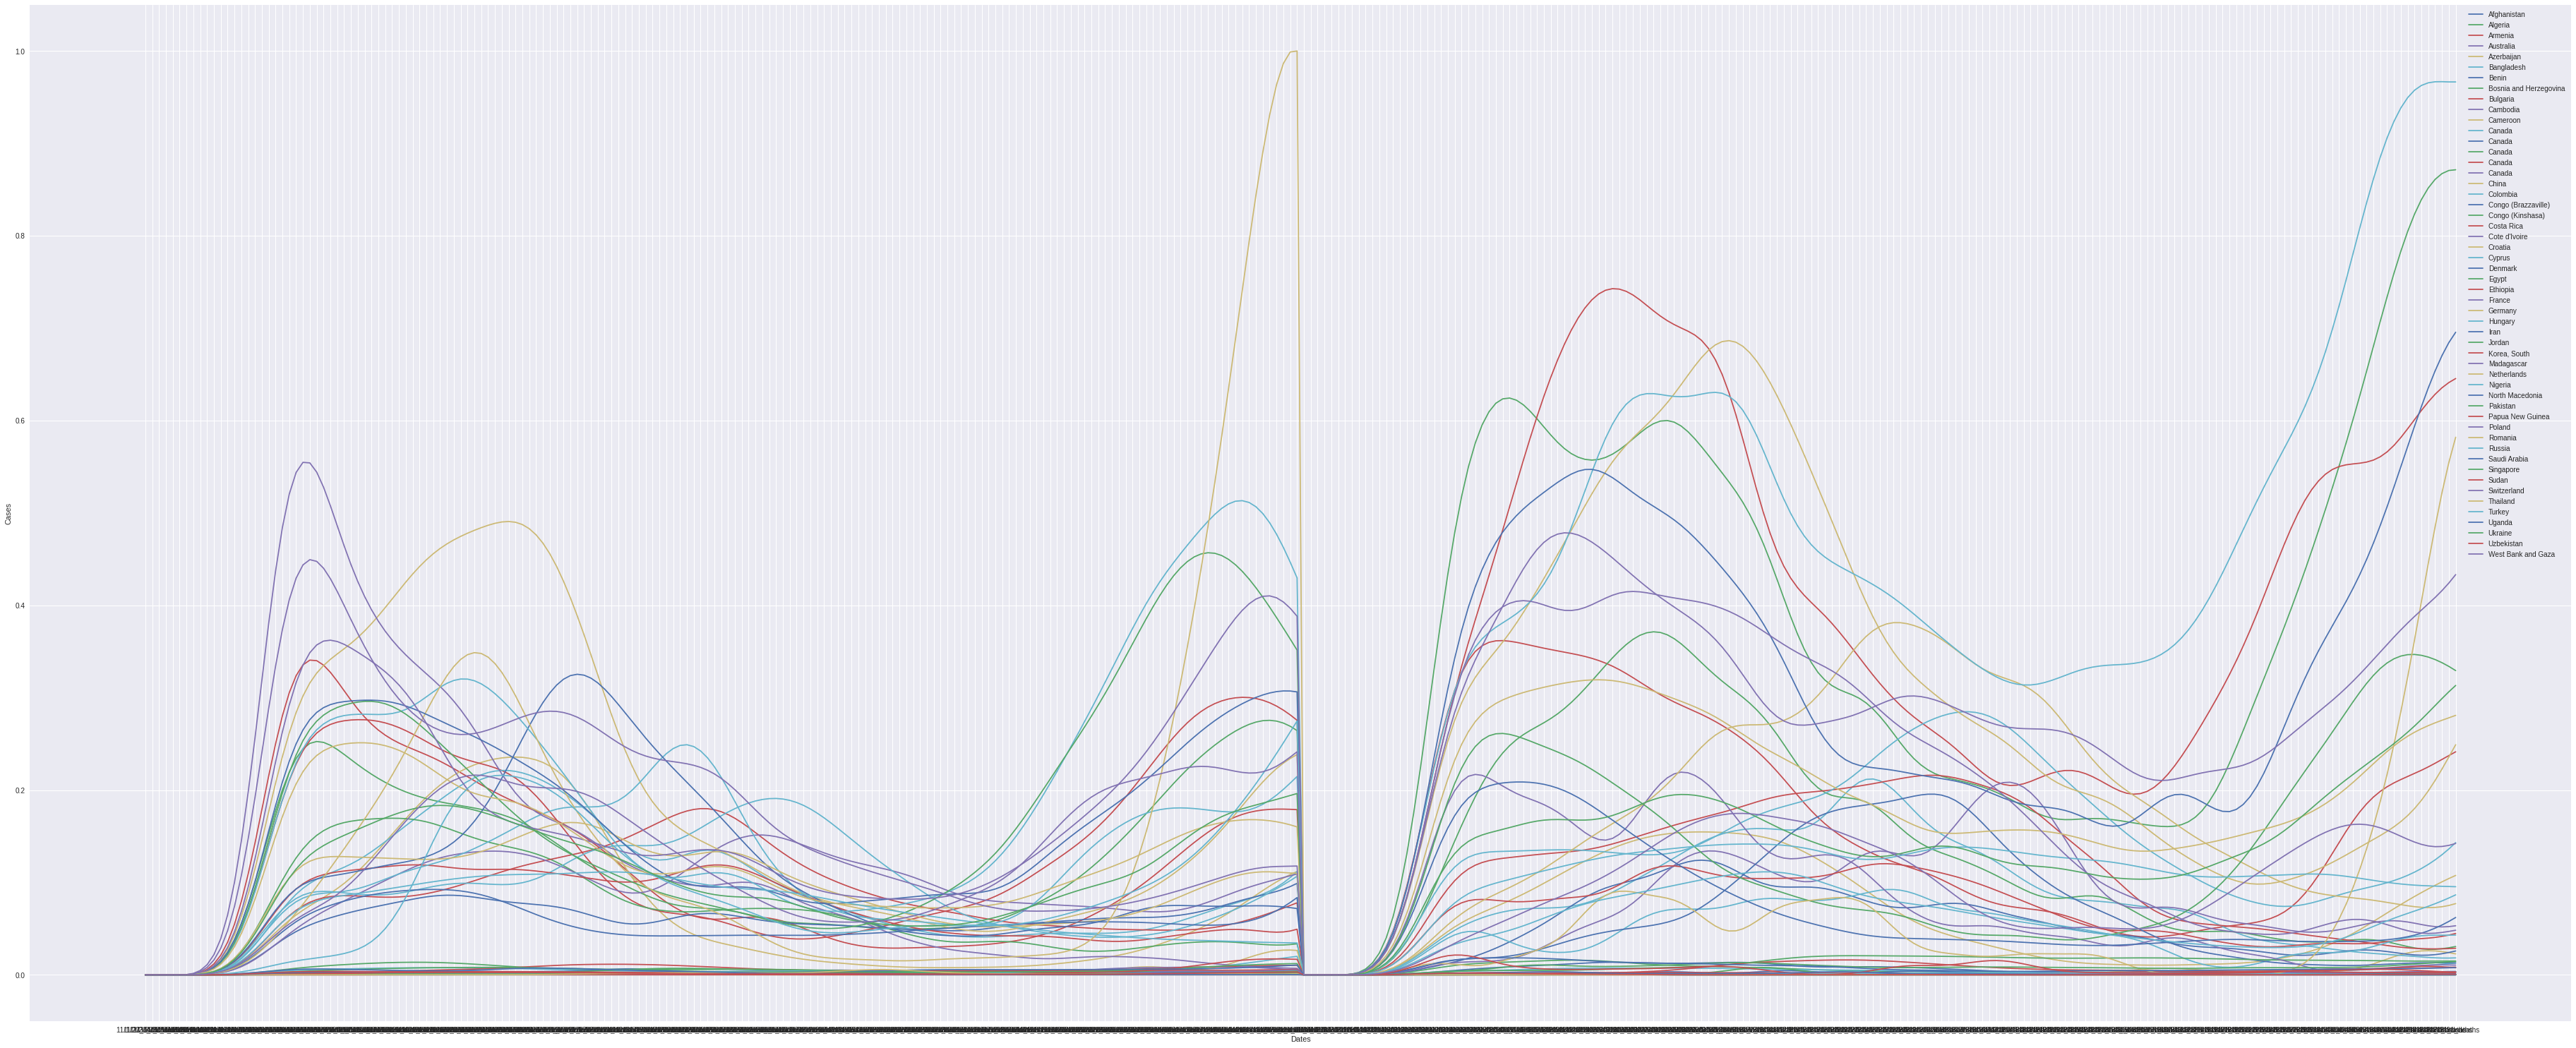

In [36]:
get_graphs(df, cluster_num=2)

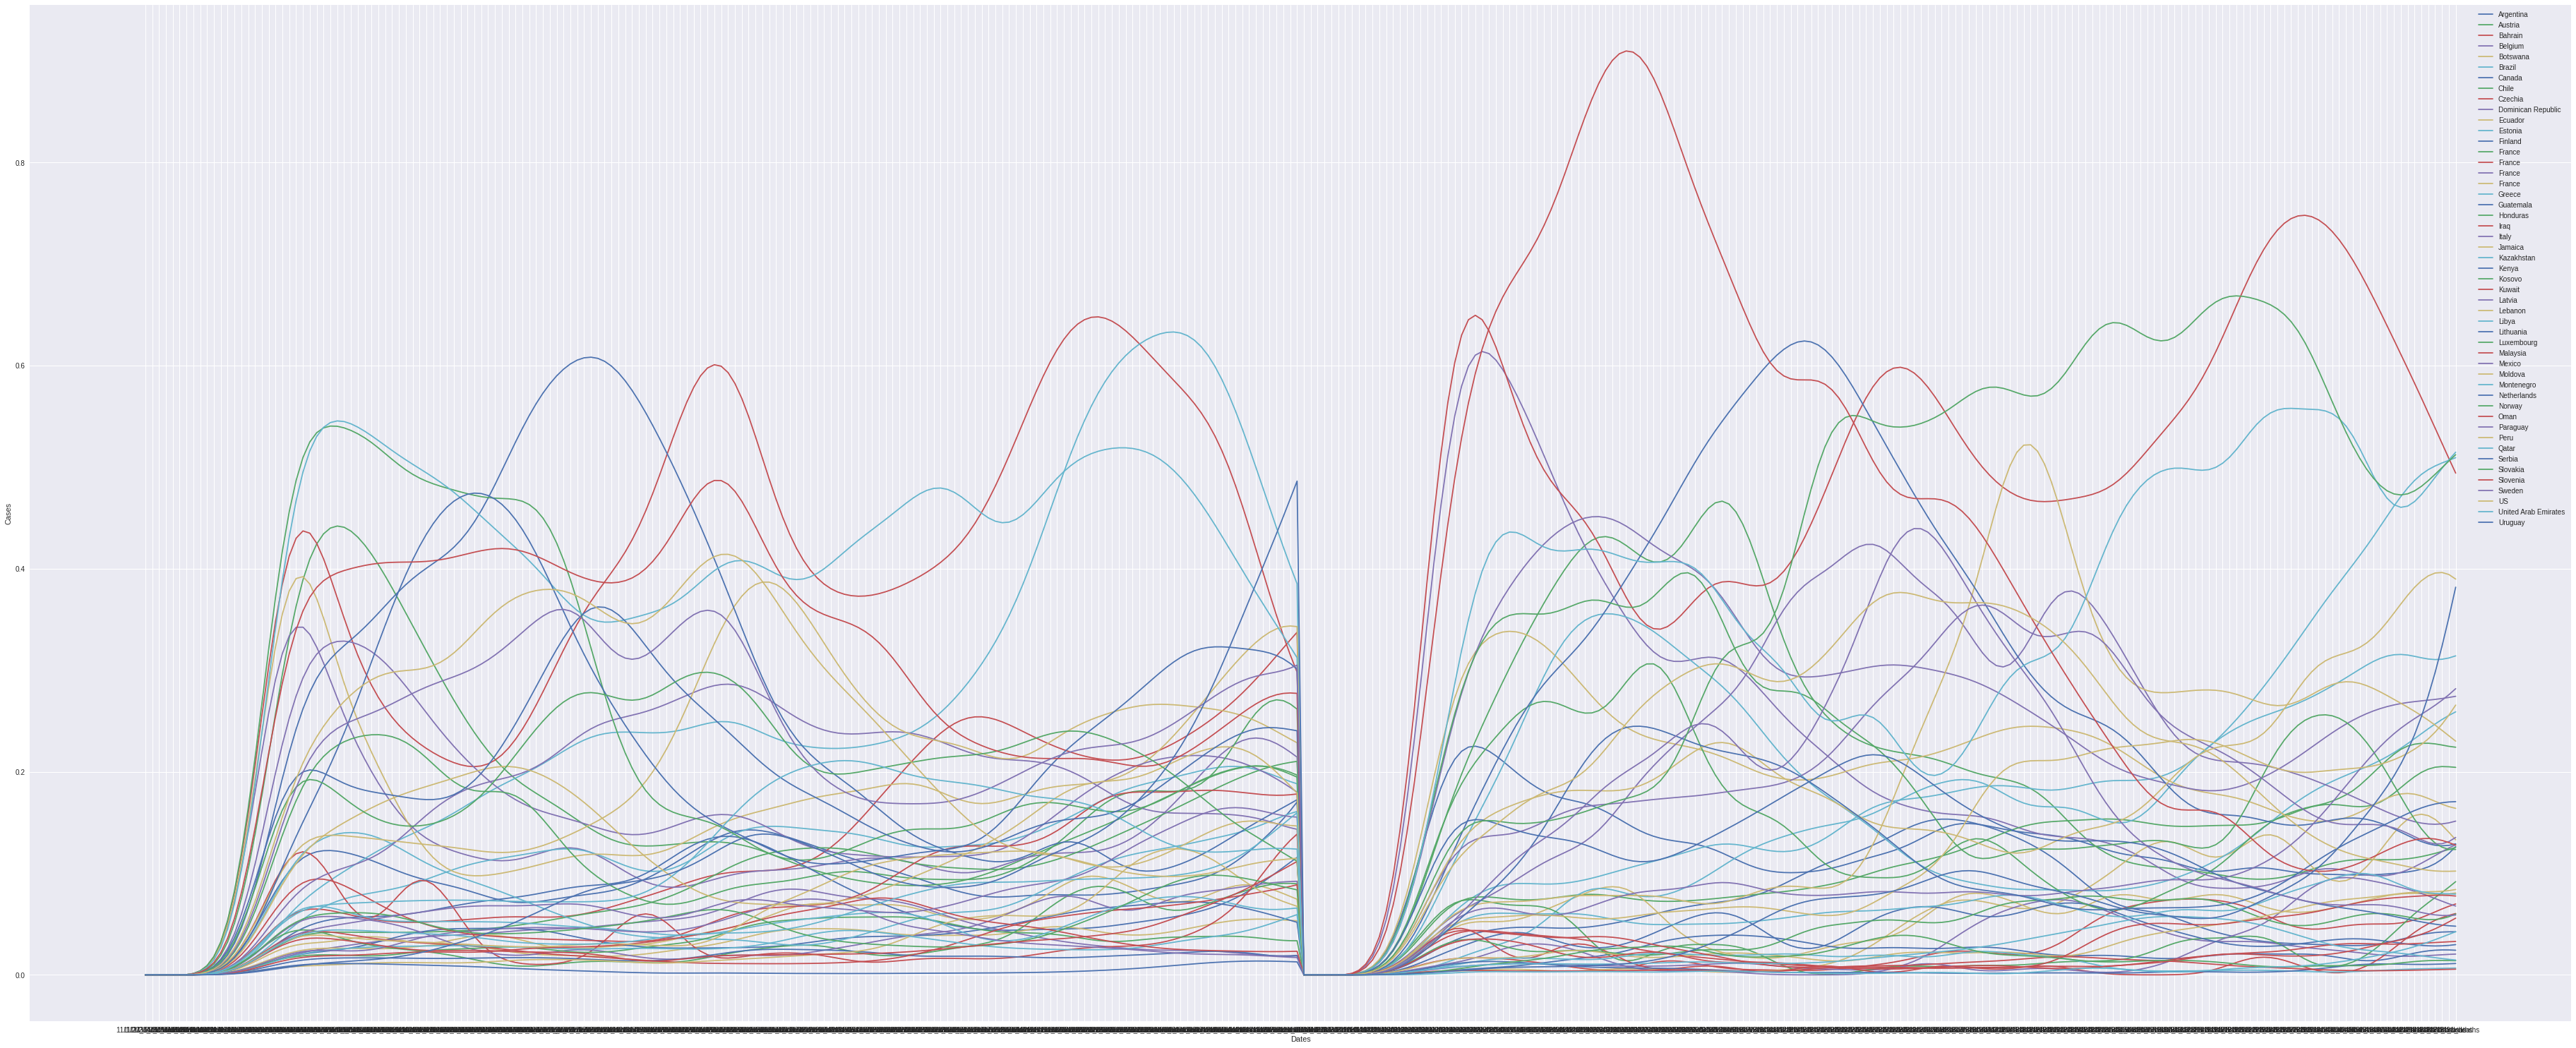

In [37]:
get_graphs(df, cluster_num=3)

In [ ]:
# get_graphs(df, cluster_num=4)

In [38]:
df.shape

(140, 362)

In [39]:
df.to_csv(os.path.join(BASE_DIR, 'new_clustered_countries_kshape_6months.csv'))